# Background and Objective
- The main objective of this project is to build a predictive model for credit card customer risk level prediction. High risk customers will not be approved when appling a higher level credict card, while low risk customers will be recommend and approved for a next level credit card.
- The datasets is provide by Kaggle: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction  One is the detailed cutomer profile, other is their overdue status records.

# Conclusion and Recommendation
## Conclusion
- The Randomforest model peformed best in the key metrics 'Recall'(recall could better prevent wrong prediction of high risk to low risk), while the Accuracy is high as 0.8034, the Recall score is still low 0.5250
- In this model, these features have great influence on the predicting result: if the customer owns a real_estate or car, and the housing type(owned by oneself or rent/live in others' house), his/her income_type, income_level, gender, age, work experience, education_level.
## Recommendation
- Since Recall score is still low, this model still have limitation and could be further improved.
- Plan: advanced imbalanced data hanlding methods except SMOTE, advanced model like deep learning methods

# Process and Explanation
- 1. Define risk and merge two dataset into one df: high risk: overdue more than 30 days or bad debts, low risk: paid off or No loan for the month, or 1-29 days past due; since one customer has several months records, choose the highest risk one as his or her record; merge dataset according to client ID
- 2. Clean data: fillna for occupation type, clean outliers in income and family number, drop unuseful columns
- 3. Feature engineering: reset some features by groups, like reset occupation according to the occupation characteristics, turn birth day to age, etc.
- 4. EDA: boxplot for numerical features, percentage tables for categorical feature, choose obviously distinctive features and put in the model
- 5. Pipeline: one hot encoding for categorical features, StandardScaler for numerical features, apply SMOTE to resample the imbalanced data(since target variable 'risk' is imbalanced)
- 6. Prepare baseline: use baseline models and f1 score to choose models for next step hyperparameter, choose Randomforest and Decision Tree to further develop
- 7. Modelling: hyperparamter and crossvalidation, Randomforest performed better in Recall score
- 8. Ensemble methods: since recall score of Randomforest is not ideal enough, try voting and stacking methods, but the metrics are not improved 

In [2]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline

read data

In [4]:
application= pd.read_csv('/Users/junboli/Documents/Schulich/Summer 2023/datascience/Group Project/Credit Card Prediction/application_record.csv')
record = pd.read_csv('/Users/junboli/Documents/Schulich/Summer 2023/datascience/Group Project/Credit Card Prediction/credit_record.csv')

In [5]:
application.info()
# seems object are categorical variables and need to do some transfer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [6]:
application.describe(include='all')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
count,4.385570e+05,438557,438557,438557,438557.000000,4.385570e+05,438557,438557,438557,438557,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,304354,438557.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN
freq,NaN,294440,275459,304074,NaN,NaN,226104,301821,299828,393831,NaN,NaN,NaN,NaN,NaN,NaN,78240,NaN
mean,6.022176e+06,NaN,NaN,NaN,0.427390,1.875243e+05,NaN,NaN,NaN,NaN,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,NaN,2.194465
std,5.716370e+05,NaN,NaN,NaN,0.724882,1.100869e+05,NaN,NaN,NaN,NaN,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,NaN,0.897207
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.610000e+04,NaN,NaN,NaN,NaN,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000
25%,5.609375e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000
50%,6.047745e+06,NaN,NaN,NaN,0.000000,1.607805e+05,NaN,NaN,NaN,NaN,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000
75%,6.456971e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000


In [7]:
record.info()
# record's data are more than application

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [8]:
record.describe(include='all')

,ID,MONTHS_BALANCE,STATUS
count,1.048575e+06,1.048575e+06,1048575
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,442031
mean,5.068286e+06,-1.913700e+01,NaN
std,4.615058e+04,1.402350e+01,NaN
min,5.001711e+06,-6.000000e+01,NaN
25%,5.023644e+06,-2.900000e+01,NaN
50%,5.062104e+06,-1.700000e+01,NaN
75%,5.113856e+06,-7.000000e+00,NaN


In [9]:
record.head()
# each client may have multiple status and month record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


measure the value in record df

In [10]:
#before merge we need to define the record data we want to use for a client
#1. look into record
print(record['STATUS'].unique())

['X' '0' 'C' '1' '2' '3' '4' '5']


In [11]:
record.groupby('STATUS')['ID'].count()
# if multipe in groupby we could use unstack()

STATUS
0    383120
1     11090
2       868
3       320
4       223
5      1693
C    442031
X    209230
Name: ID, dtype: int64

In [12]:
#redefine the value of status, C,X: -1
#the original defination: 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month
def score (x):
    if x == 'C' or x =='X':
        return -1
    if x == '0':
        return 0
    if x == '1':
        return 1
    if x == '2':
        return 2
    if x == '3':
        return 3
    if x == '4':
        return 4
    if x == '5':
        return 5
    else:
        return 'NUll'

record['STATUS']=record['STATUS'].apply(score)

In [13]:
record.groupby('STATUS')['ID'].count()

STATUS
-1    651261
 0    383120
 1     11090
 2       868
 3       320
 4       223
 5      1693
Name: ID, dtype: int64

In [14]:
#choose the max risk level for each client
record_new = record.groupby('ID')['STATUS'].max().reset_index()#need to reset_index
#rename columns
record_new.columns=['ID','risk_level']
record_new.groupby('risk_level')['ID'].count()

risk_level
-1     5953
 0    34682
 1     4683
 2      336
 3       88
 4       48
 5      195
Name: ID, dtype: int64

In [15]:
# define risk: 
# low/non risk: paid off that month, or No loan for the month, or 1-29 days past due; 
# high risk: Overdue more than 30 days or bad debts
def risk (x):
    if x < 1:
        return 0
    else:
        return 1

record_new['risk_level']=record_new['risk_level'].apply(risk)
record_new.groupby('risk_level')['ID'].count()

risk_level
0    40635
1     5350
Name: ID, dtype: int64

Merge two tables

In [16]:
df= pd.merge(record_new, application, how='inner', on=['ID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   risk_level           36457 non-null  int64  
 2   CODE_GENDER          36457 non-null  object 
 3   FLAG_OWN_CAR         36457 non-null  object 
 4   FLAG_OWN_REALTY      36457 non-null  object 
 5   CNT_CHILDREN         36457 non-null  int64  
 6   AMT_INCOME_TOTAL     36457 non-null  float64
 7   NAME_INCOME_TYPE     36457 non-null  object 
 8   NAME_EDUCATION_TYPE  36457 non-null  object 
 9   NAME_FAMILY_STATUS   36457 non-null  object 
 10  NAME_HOUSING_TYPE    36457 non-null  object 
 11  DAYS_BIRTH           36457 non-null  int64  
 12  DAYS_EMPLOYED        36457 non-null  int64  
 13  FLAG_MOBIL           36457 non-null  int64  
 14  FLAG_WORK_PHONE      36457 non-null  int64  
 15  FLAG_PHONE           36457 non-null 

In [17]:
df.describe(include='all')

,ID,risk_level,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
count,3.645700e+04,36457.000000,36457,36457,36457,36457.000000,3.645700e+04,36457,36457,36457,36457,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,25134,36457.000000
unique,NaN,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN
top,NaN,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN
freq,NaN,NaN,24430,22614,24506,NaN,NaN,18819,24777,25048,32548,NaN,NaN,NaN,NaN,NaN,NaN,6211,NaN
mean,5.078227e+06,0.117700,NaN,NaN,NaN,0.430315,1.866857e+05,NaN,NaN,NaN,NaN,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,NaN,2.198453
std,4.187524e+04,0.322257,NaN,NaN,NaN,0.742367,1.017892e+05,NaN,NaN,NaN,NaN,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,NaN,0.911686
min,5.008804e+06,0.000000,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000
25%,5.042028e+06,0.000000,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000
50%,5.074614e+06,0.000000,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000
75%,5.115396e+06,0.000000,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000


# Data Cleaning

1. FillNA

In [18]:
#only occupation_type has missing, let's see
df['OCCUPATION_TYPE'].fillna('unknown', inplace=True)
df.groupby('OCCUPATION_TYPE')['ID'].count()
#too much unknown, see if it will affect the total data

OCCUPATION_TYPE
Accountants               1241
Cleaning staff             551
Cooking staff              655
Core staff                3591
Drivers                   2138
HR staff                    85
High skill tech staff     1383
IT staff                    60
Laborers                  6211
Low-skill Laborers         175
Managers                  3012
Medicine staff            1207
Private service staff      344
Realty agents               79
Sales staff               3485
Secretaries                151
Security staff             592
Waiters/barmen staff       174
unknown                  11323
Name: ID, dtype: int64

In [19]:
df.groupby(['OCCUPATION_TYPE','risk_level'])['ID'].count().unstack()

risk_level,0,1
OCCUPATION_TYPE,,
Accountants,1094,147
Cleaning staff,488,63
Cooking staff,569,86
Core staff,3128,463
Drivers,1874,264
HR staff,71,14
High skill tech staff,1202,181
IT staff,49,11
Laborers,5481,730


In [20]:
df.groupby('OCCUPATION_TYPE')['AMT_INCOME_TOTAL'].mean()

OCCUPATION_TYPE
Accountants              202463.865834
Cleaning staff           149141.107078
Cooking staff            146517.251908
Core staff               190172.786967
Drivers                  209797.240412
HR staff                 193764.705882
High skill tech staff    196053.579176
IT staff                 199860.000000
Laborers                 179794.282402
Low-skill Laborers       133920.000000
Managers                 279117.292829
Medicine staff           166114.618061
Private service staff    198863.372093
Realty agents            247500.000000
Sales staff              174984.897848
Secretaries              168079.470199
Security staff           177037.753378
Waiters/barmen staff     156206.896552
unknown                  168599.123819
Name: AMT_INCOME_TOTAL, dtype: float64

2. Clean Outliers

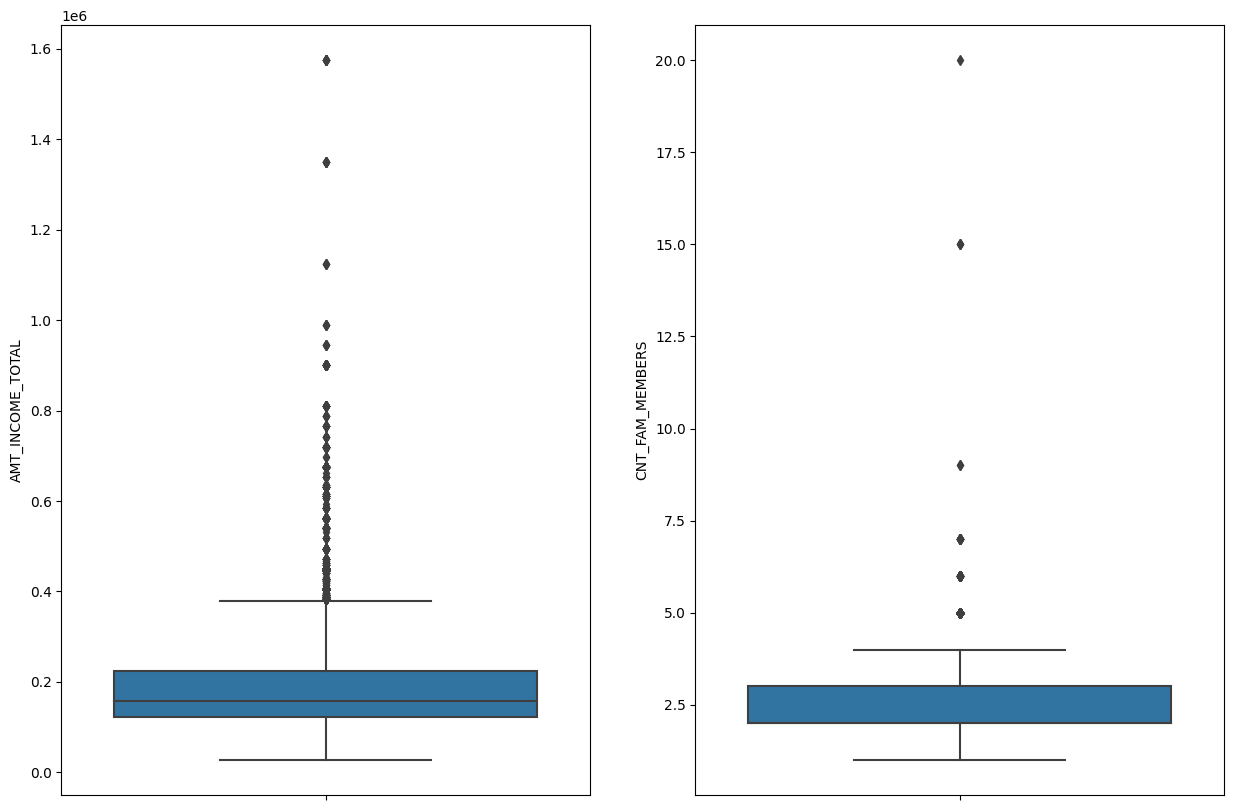

In [21]:
#see if outliers in numerical data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
sns.boxplot(data=df, y='AMT_INCOME_TOTAL', ax=ax1)
sns.boxplot(data=df, y='CNT_FAM_MEMBERS', ax=ax2)
plt.show()

In [22]:
#clean outliers
drop_income_outliers = df[df['AMT_INCOME_TOTAL']>1000000].index
drop_fam_outliers = df[df['CNT_FAM_MEMBERS']>7].index

In [23]:
df.drop(drop_income_outliers, inplace=True)
df.drop(drop_fam_outliers, inplace=True)


3. clean duplicated

In [24]:
#let's drop any duplicate entries.
df.drop_duplicates(inplace=True)

## reset some varibales

1. reset occupation according to the occupation characteristics

In [25]:
#reset occupation to only several groups
def occupation (x):
    if x == 'Accountants' or x == 'Core staff' or x=='High skill tech staff' or x=='IT staff' or x=='Private service staff' or x=='HR staff':
        return 'professional/highskill'
    if x=='Cleaning staff' or x=='Cooking staff' or x=='Medicine staff' or x=='Sales staff' or x=='Secretaries' or x=='Security staff' or x=='Waiters/barmen staff':
        return 'normal_staff'
    if x=='Managers'or x=='Realty agents' or x=='Drivers':
        return 'Management/entrepreneur'
    if x=='Laborers' or x =='Low-skill Laborers':
        return 'labours/none'
    else:
        return 'unknown'

df['occupation']=df['OCCUPATION_TYPE'].apply(occupation)

In [26]:
df['occupation'].unique()

array(['unknown', 'normal_staff', 'professional/highskill',
       'labours/none', 'Management/entrepreneur'], dtype=object)

In [27]:
df.groupby('occupation')['AMT_INCOME_TOTAL'].mean()

occupation
Management/entrepreneur    246506.102131
labours/none               178537.157532
normal_staff               168145.495156
professional/highskill     194239.384770
unknown                    168599.123819
Name: AMT_INCOME_TOTAL, dtype: float64

2. turn days brith to age

In [28]:
#turn DAYS_BIRTH to age
df['Age']=(0-df['DAYS_BIRTH'])//365 #//just leave int
df['Age']

0        32
1        32
2        58
3        52
4        52
         ..
36452    29
36453    29
36454    29
36455    29
36456    53
Name: Age, Length: 36434, dtype: int64

3. turn days employed to work years

In [29]:
#turn DAYS_EMPLOYED to work year
df['Workyear']=(0-df['DAYS_EMPLOYED'])//365
df['Workyear']

0        12
1        12
2         3
3         8
4         8
         ..
36452     4
36453     4
36454     4
36455     4
36456     5
Name: Workyear, Length: 36434, dtype: int64

4. reset income to categorical levels

<Figure size 1200x600 with 0 Axes>

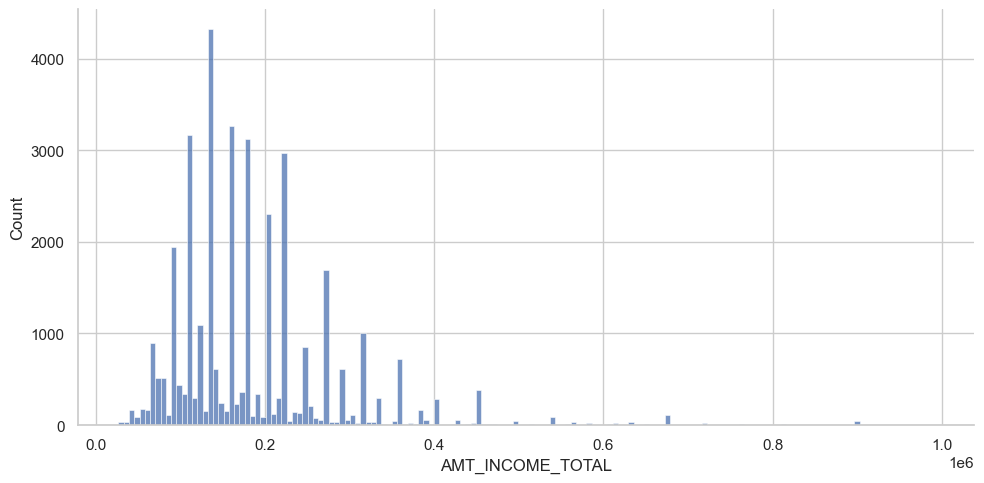

In [30]:
# Create a displot with a longer x-axis
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  # Adjust the figure size to control overall dimensions

sns.displot(data=df, x='AMT_INCOME_TOTAL', height=5, aspect=2)  # Adjust height and aspect as needed

plt.show()

In [31]:
#income level: 1-below 100000 , 2-100000~150000, 3-150000~200000, 4-200000~300000, 5-above 300000
def income (x):
    if x <100000:
        return 1
    if x>=100000 and x<150000:
        return 2
    if x>=150000 and x<200000:
        return 3
    if x>=200000 and x<300000:
        return 4
    else:
        return 5

df['income_level']=df['AMT_INCOME_TOTAL'].apply(income)

In [32]:
df.groupby('income_level')['ID'].count()

income_level
1     5086
2    10235
3     7659
4     9642
5     3812
Name: ID, dtype: int64

5. regroup NAME_EDUCATION_TYPE

<Figure size 1200x600 with 0 Axes>

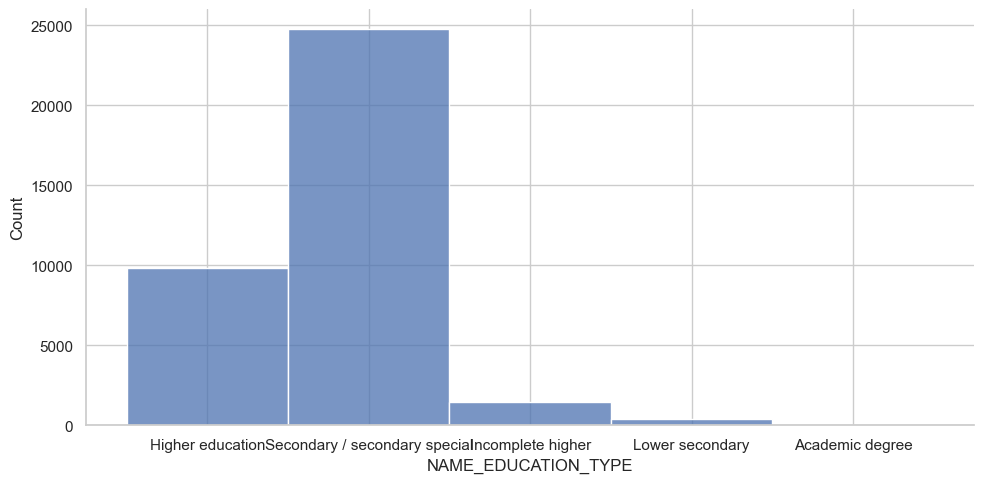

In [33]:
# Create a displot with a longer x-axis
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  # Adjust the figure size to control overall dimensions

sns.displot(data=df, x='NAME_EDUCATION_TYPE', height=5, aspect=2)  # Adjust height and aspect as needed

plt.show()

In [34]:
#convert to 2 categories: higher education/incomplete higher/academic 1, secondary or lower 0
def education (x):
    if x =='Higher educatuon' or x=='Incomplete higher' or x=='Academic degree':
        return 1
    else:
        return 0

df['education_level']=df['NAME_EDUCATION_TYPE'].apply(education)

In [35]:
df.groupby('education_level')['ID'].count()

education_level
0    34992
1     1442
Name: ID, dtype: int64

6. regroup NAME_FAMILY_STATUS

<Figure size 1200x600 with 0 Axes>

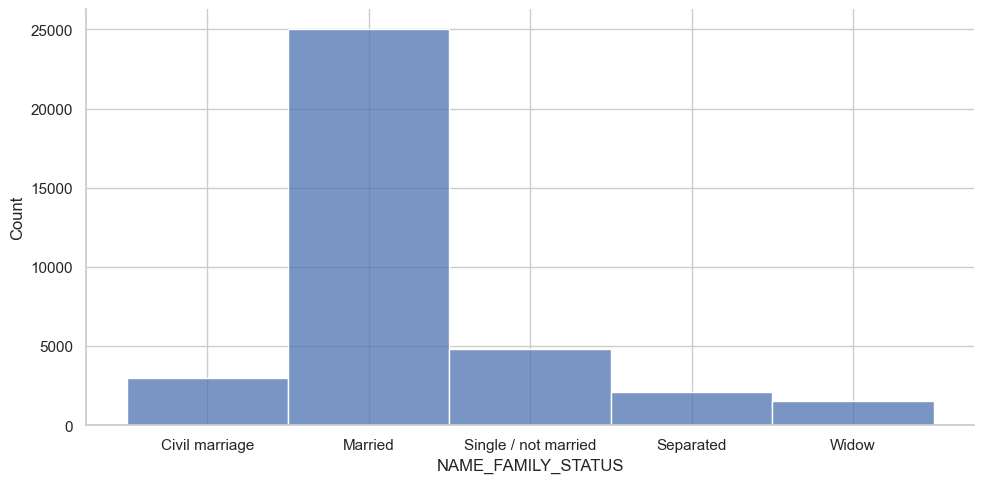

In [36]:
# Create a displot with a longer x-axis
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  # Adjust the figure size to control overall dimensions

sns.displot(data=df, x='NAME_FAMILY_STATUS', height=5, aspect=2)  # Adjust height and aspect as needed

plt.show()

In [37]:
#convert to 2 categories: married 1, unmarried 0
def marriage (x):
    if x =='Civil marriage' or x=='Married':
        return 1
    else:
        return 0

df['marriage_status']=df['NAME_FAMILY_STATUS'].apply(marriage)

In [38]:
df.groupby('marriage_status')['ID'].count()

marriage_status
0     8452
1    27982
Name: ID, dtype: int64

7. regroup income  NAME_INCOME_TYPE

<Figure size 1200x600 with 0 Axes>

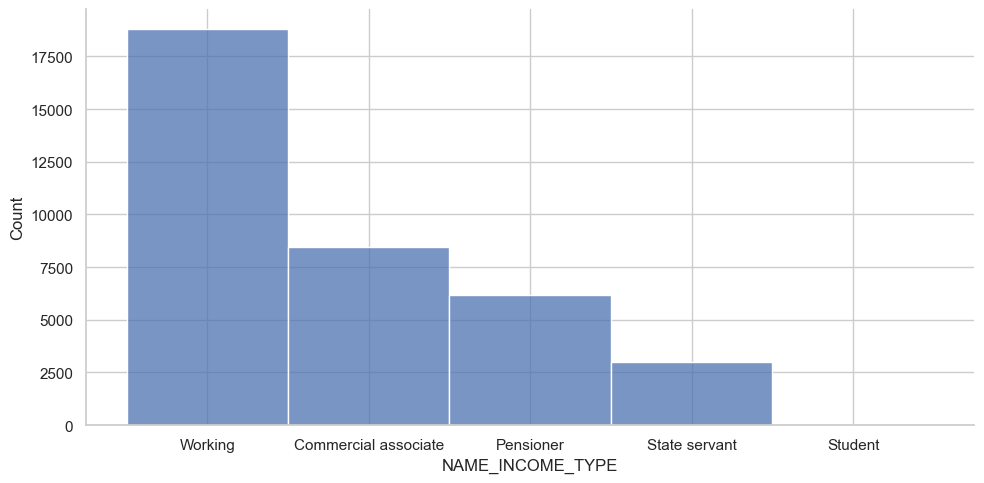

In [39]:
# Create a displot with a longer x-axis
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  # Adjust the figure size to control overall dimensions

sns.displot(data=df, x='NAME_INCOME_TYPE', height=5, aspect=2)  # Adjust height and aspect as needed

plt.show()

In [40]:
#convert to 2 categories: working 1, non-working 0
def incometype (x):
    if x =='Working':
        return 1
    else:
        return 0

df['income_type']=df['NAME_INCOME_TYPE'].apply(incometype)

In [41]:
df.groupby('income_type')['ID'].count()

income_type
0    17622
1    18812
Name: ID, dtype: int64

8. regroup NAME_HOUSING_TYPE

In [42]:
#convert to 2 categories: house/apartment 1, not totally owned 0
def housetype (x):
    if x =='House / apartment':
        return 1
    else:
        return 0

df['house_type']=df['NAME_HOUSING_TYPE'].apply(housetype)

In [43]:
df.groupby('house_type')['ID'].count()

house_type
0     3902
1    32532
Name: ID, dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36434 entries, 0 to 36456
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36434 non-null  int64  
 1   risk_level           36434 non-null  int64  
 2   CODE_GENDER          36434 non-null  object 
 3   FLAG_OWN_CAR         36434 non-null  object 
 4   FLAG_OWN_REALTY      36434 non-null  object 
 5   CNT_CHILDREN         36434 non-null  int64  
 6   AMT_INCOME_TOTAL     36434 non-null  float64
 7   NAME_INCOME_TYPE     36434 non-null  object 
 8   NAME_EDUCATION_TYPE  36434 non-null  object 
 9   NAME_FAMILY_STATUS   36434 non-null  object 
 10  NAME_HOUSING_TYPE    36434 non-null  object 
 11  DAYS_BIRTH           36434 non-null  int64  
 12  DAYS_EMPLOYED        36434 non-null  int64  
 13  FLAG_MOBIL           36434 non-null  int64  
 14  FLAG_WORK_PHONE      36434 non-null  int64  
 15  FLAG_PHONE           36434 non-null  int6

## Clean the final df

1. clean outliers after feature engineering

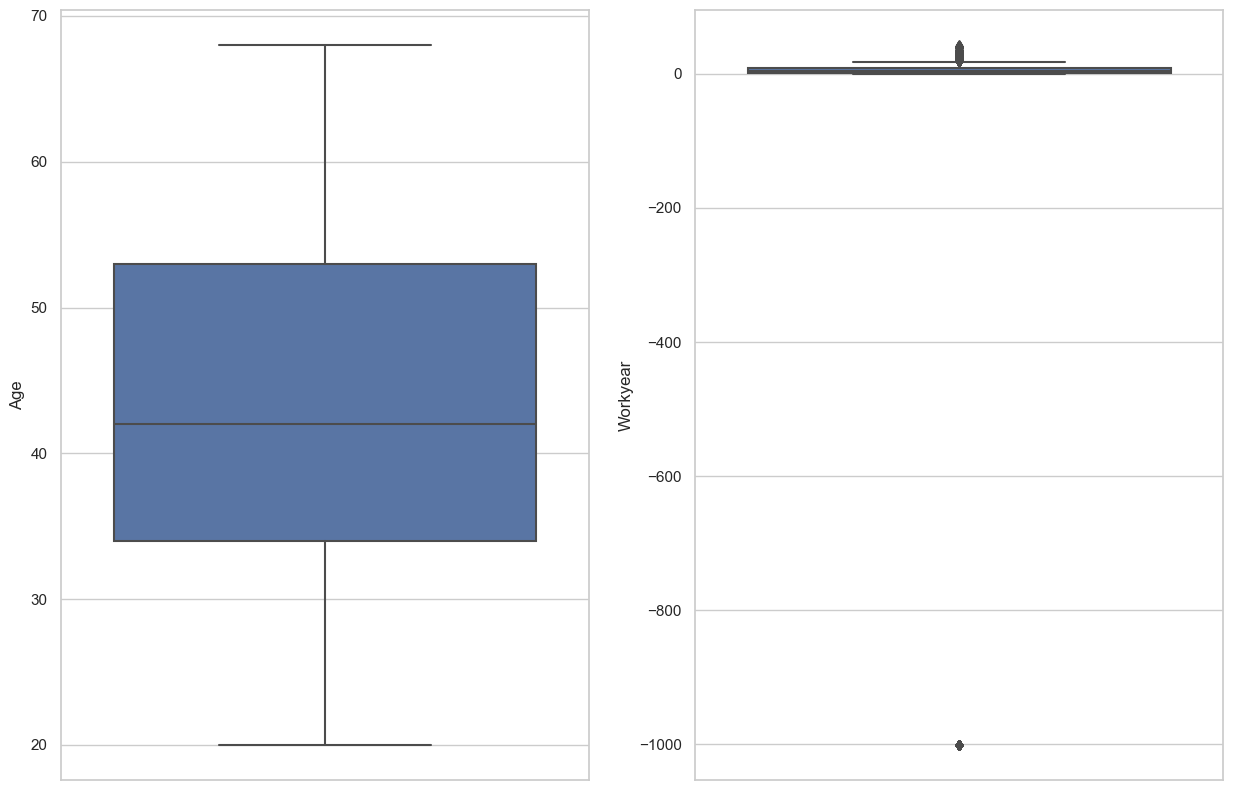

In [45]:
#see if outliers in numerical data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
sns.boxplot(data=df, y='Age', ax=ax1)
sns.boxplot(data=df, y='Workyear', ax=ax2)
plt.show()

In [46]:
drop_work_outliers = df[df['Workyear']<0].index

In [47]:
df.drop(drop_work_outliers, inplace=True)

<Axes: ylabel='Workyear'>

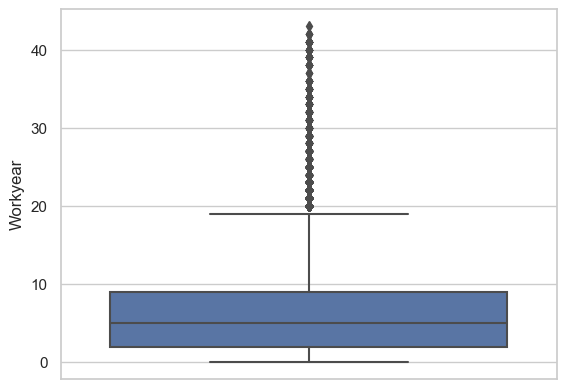

In [48]:
sns.boxplot(data=df, y='Workyear')

2. drop unuseful columns

In [49]:
#drop some not useful columns
columns_to_drop = ['OCCUPATION_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','AMT_INCOME_TOTAL','NAME_INCOME_TYPE','NAME_HOUSING_TYPE']
df.drop(columns=columns_to_drop, inplace=True)

In [50]:
df.head()

,ID,risk_level,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,occupation,Age,Workyear,income_level,education_level,marriage_status,income_type,house_type
0,5008804,1,M,Y,Y,0,1,1,0,0,2.0,unknown,32,12,5,0,1,1,0
1,5008805,1,M,Y,Y,0,1,1,0,0,2.0,unknown,32,12,5,0,1,1,0
2,5008806,0,M,Y,Y,0,1,0,0,0,2.0,normal_staff,58,3,2,0,1,1,1
3,5008808,0,F,N,Y,0,1,0,1,1,1.0,normal_staff,52,8,4,0,0,0,1
4,5008809,0,F,N,Y,0,1,0,1,1,1.0,normal_staff,52,8,4,0,0,0,1


In [51]:
#rename columns
df.columns=['ID','risk_level', 'gender', 'car', 'real_estate', 'number_children', 'mobile','work_phone','phone','email','number_fam_members','occupation','age','work_year','income_level','education_level','marriage_status','income_type','housing_type']

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30299 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  30299 non-null  int64  
 1   risk_level          30299 non-null  int64  
 2   gender              30299 non-null  object 
 3   car                 30299 non-null  object 
 4   real_estate         30299 non-null  object 
 5   number_children     30299 non-null  int64  
 6   mobile              30299 non-null  int64  
 7   work_phone          30299 non-null  int64  
 8   phone               30299 non-null  int64  
 9   email               30299 non-null  int64  
 10  number_fam_members  30299 non-null  float64
 11  occupation          30299 non-null  object 
 12  age                 30299 non-null  int64  
 13  work_year           30299 non-null  int64  
 14  income_level        30299 non-null  int64  
 15  education_level     30299 non-null  int64  
 16  marriage_

# EDA & Feature Selection

<Axes: xlabel='risk_level', ylabel='work_year'>

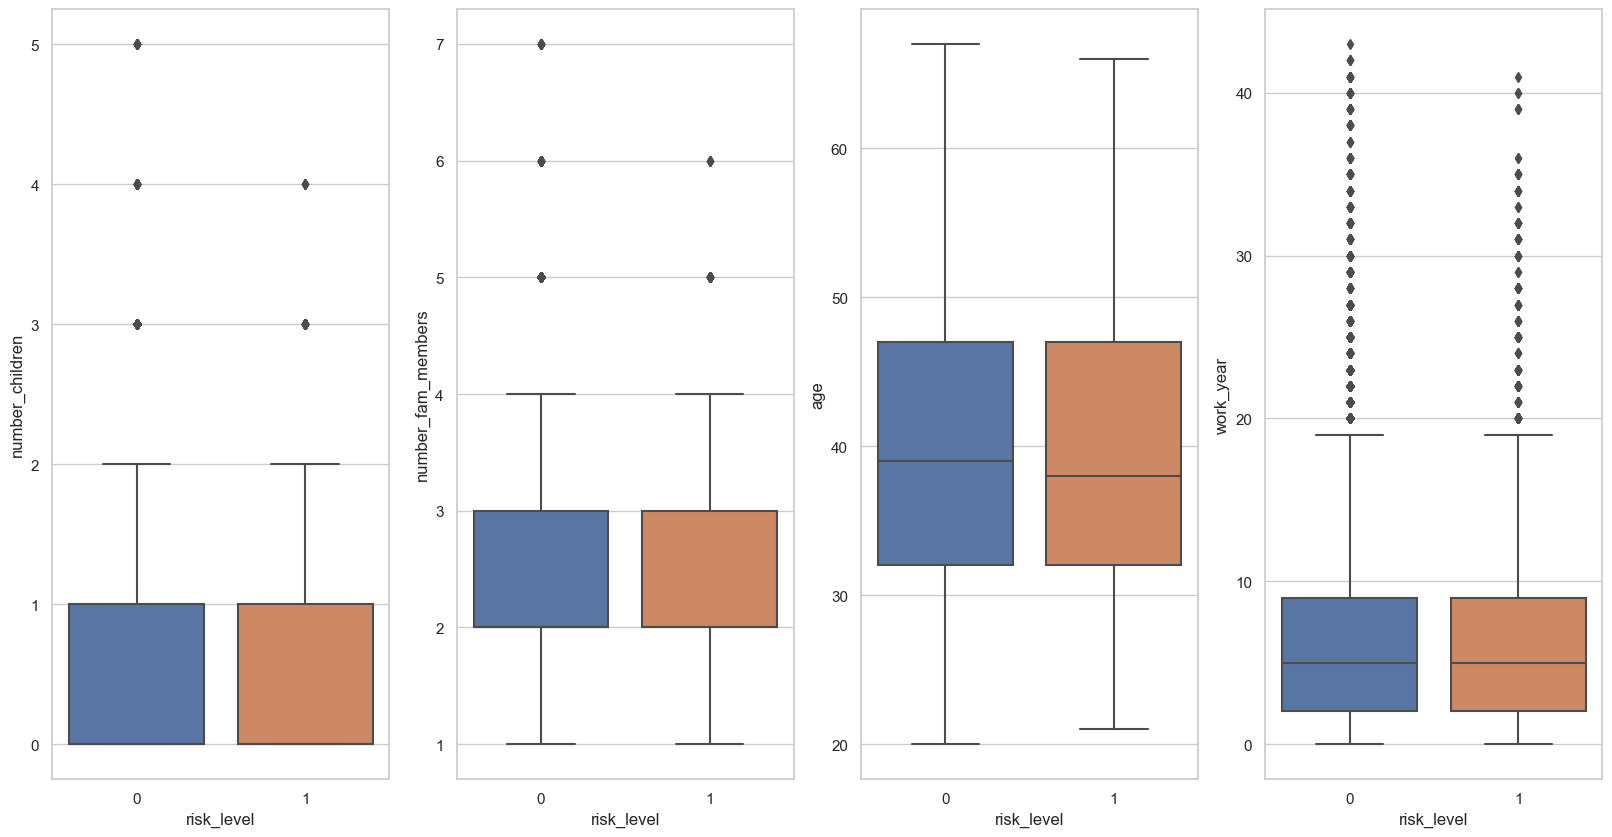

In [53]:
#fist see continous variables
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,10))
sns.boxplot(x='risk_level', y='number_children', ax=ax1, data=df)
sns.boxplot(x='risk_level', y='number_fam_members', ax=ax2, data=df)
sns.boxplot(x='risk_level', y='age', ax=ax3, data=df)
sns.boxplot(x='risk_level', y='work_year', ax=ax4, data=df)

#little difference, except age

In [54]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'gender'
cross_tab = pd.crosstab(df['risk_level'], df['gender'], margins=True, margins_name='Total')

# Calculate percentages
percentage_gen = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_gen
#Men have higher risk than Female

gender,F,M,Total
risk_level,,,
0,63.63,36.37,100.0
1,61.01,38.99,100.0
Total,63.31,36.69,100.0


In [55]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'car'
cross_tab = pd.crosstab(df['risk_level'], df['car'], margins=True, margins_name='Total')

# Calculate percentages
percentage_car = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_car
#Dont have a car have a higher risk

car,N,Y,Total
risk_level,,,
0,58.33,41.67,100.0
1,60.76,39.24,100.0
Total,58.63,41.37,100.0


In [56]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'real_estate'
cross_tab = pd.crosstab(df['risk_level'], df['real_estate'], margins=True, margins_name='Total')

# Calculate percentages
percentage_est = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_est

#dont have a real_estae have higher risk

real_estate,N,Y,Total
risk_level,,,
0,34.30,65.70,100.0
1,37.95,62.05,100.0
Total,34.74,65.26,100.0


In [57]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'income_type'
cross_tab = pd.crosstab(df['risk_level'], df['income_type'], margins=True, margins_name='Total')

# Calculate percentages
percentage_in = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_in

# non-working income higher risk

income_type,0,1,Total
risk_level,,,
0,37.57,62.43,100.0
1,40.39,59.61,100.0
Total,37.91,62.09,100.0


In [58]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'housing_type
cross_tab = pd.crosstab(df['risk_level'], df['housing_type'], margins=True, margins_name='Total')

# Calculate percentages
percentage_house = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_house

housing_type,0,1,Total
risk_level,,,
0,11.99,88.01,100.0
1,12.79,87.21,100.0
Total,12.09,87.91,100.0


In [59]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'occupation
cross_tab = pd.crosstab(df['risk_level'], df['occupation'], margins=True, margins_name='Total')

# Calculate percentages
percentage_occupation = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_occupation

occupation,Management/entrepreneur,labours/none,normal_staff,professional/highskill,unknown,Total
risk_level,,,,,,
0,17.09,21.10,22.48,22.01,17.31,100.0
1,17.91,20.89,22.51,22.95,15.74,100.0
Total,17.19,21.08,22.48,22.13,17.12,100.0


In [60]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'income_level
cross_tab = pd.crosstab(df['risk_level'], df['income_level'], margins=True, margins_name='Total')

# Calculate percentages
percentage_income_level = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_income_level

#higher income higher risk

income_level,1,2,3,4,5,Total
risk_level,,,,,,
0,11.24,27.28,21.91,27.82,11.75,100.0
1,10.71,26.70,19.41,30.83,12.35,100.0
Total,11.18,27.21,21.61,28.18,11.82,100.0


In [61]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'education_level 
cross_tab = pd.crosstab(df['risk_level'], df['education_level'], margins=True, margins_name='Total')

# Calculate percentages
percentage_education_level = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_education_level 


education_level,0,1,Total
risk_level,,,
0,95.57,4.43,100.0
1,94.47,5.53,100.0
Total,95.44,4.56,100.0


In [62]:
# Create a crosstab to get counts for each combination of 'risk_level' and 'marriage_status 
cross_tab = pd.crosstab(df['risk_level'], df['marriage_status'], margins=True, margins_name='Total')

# Calculate percentages
percentage_marriage_status = (cross_tab.div(cross_tab['Total'], axis=0) * 100).round(2)
percentage_marriage_status 

marriage_status,0,1,Total
risk_level,,,
0,21.74,78.26,100.0
1,22.04,77.96,100.0
Total,21.78,78.22,100.0


## Hypothesis: 
- the inluence of the features: real_estate > income_type > income_level > gender > car > age > work year > education_level > housing_type

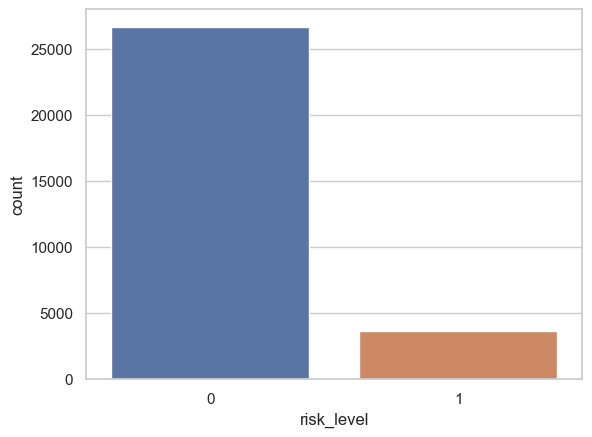

In [63]:
#imbalanced target variable
sns.countplot(x='risk_level', data=df)
plt.show()

convert object to number

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30299 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  30299 non-null  int64  
 1   risk_level          30299 non-null  int64  
 2   gender              30299 non-null  object 
 3   car                 30299 non-null  object 
 4   real_estate         30299 non-null  object 
 5   number_children     30299 non-null  int64  
 6   mobile              30299 non-null  int64  
 7   work_phone          30299 non-null  int64  
 8   phone               30299 non-null  int64  
 9   email               30299 non-null  int64  
 10  number_fam_members  30299 non-null  float64
 11  occupation          30299 non-null  object 
 12  age                 30299 non-null  int64  
 13  work_year           30299 non-null  int64  
 14  income_level        30299 non-null  int64  
 15  education_level     30299 non-null  int64  
 16  marriage_

In [65]:
df.head()

,ID,risk_level,gender,car,real_estate,number_children,mobile,work_phone,phone,email,number_fam_members,occupation,age,work_year,income_level,education_level,marriage_status,income_type,housing_type
0,5008804,1,M,Y,Y,0,1,1,0,0,2.0,unknown,32,12,5,0,1,1,0
1,5008805,1,M,Y,Y,0,1,1,0,0,2.0,unknown,32,12,5,0,1,1,0
2,5008806,0,M,Y,Y,0,1,0,0,0,2.0,normal_staff,58,3,2,0,1,1,1
3,5008808,0,F,N,Y,0,1,0,1,1,1.0,normal_staff,52,8,4,0,0,0,1
4,5008809,0,F,N,Y,0,1,0,1,1,1.0,normal_staff,52,8,4,0,0,0,1


In [66]:
# Define the mapping for 'M' and 'F' to 1 and 0, respectively
mapping = {'M': 1, 'F': 0}
# Convert the categorical columns to 0 and 1 using the map() function
cat_columns = ['gender']
df[cat_columns] = df[cat_columns].apply(lambda x: x.map(mapping))

In [67]:
# Define the mapping for 'Y' and 'N' to 1 and 0, respectively
mapping = {'Y': 1, 'N': 0}

# Convert the categorical columns to 0 and 1 using the map() function
cat_columns = ['car', 'real_estate']
df[cat_columns] = df[cat_columns].apply(lambda x: x.map(mapping))

In [68]:
# Define the list of categorical columns
cat_columns = ['housing_type', 'occupation']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in cat_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30299 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  30299 non-null  int64  
 1   risk_level          30299 non-null  int64  
 2   gender              30299 non-null  int64  
 3   car                 30299 non-null  int64  
 4   real_estate         30299 non-null  int64  
 5   number_children     30299 non-null  int64  
 6   mobile              30299 non-null  int64  
 7   work_phone          30299 non-null  int64  
 8   phone               30299 non-null  int64  
 9   email               30299 non-null  int64  
 10  number_fam_members  30299 non-null  float64
 11  occupation          30299 non-null  int64  
 12  age                 30299 non-null  int64  
 13  work_year           30299 non-null  int64  
 14  income_level        30299 non-null  int64  
 15  education_level     30299 non-null  int64  
 16  marriage_

In [70]:
df.head()

,ID,risk_level,gender,car,real_estate,number_children,mobile,work_phone,phone,email,number_fam_members,occupation,age,work_year,income_level,education_level,marriage_status,income_type,housing_type
0,5008804,1,1,1,1,0,1,1,0,0,2.0,4,32,12,5,0,1,1,0
1,5008805,1,1,1,1,0,1,1,0,0,2.0,4,32,12,5,0,1,1,0
2,5008806,0,1,1,1,0,1,0,0,0,2.0,2,58,3,2,0,1,1,1
3,5008808,0,0,0,1,0,1,0,1,1,1.0,2,52,8,4,0,0,0,1
4,5008809,0,0,0,1,0,1,0,1,1,1.0,2,52,8,4,0,0,0,1


# Pipeline

import smote to handle imbalanced data

In [71]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

real_estate > income_type > income_level > gender > car > age

In [72]:
cat_columns = ['real_estate', 'income_type','income_level','gender','car','education_level','housing_type']
num_columns = ['age','work_year']
target = 'risk_level'

# Separate features and target
X = df[cat_columns + num_columns]
y = df[target]

In [73]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [74]:
# Preprocessing
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_columns),
    ('num', num_transformer, num_columns)
])

In [75]:
# Combine transformers with SMOTE: after processing, SMOTE technique will only be applied to the training data
smote = SMOTE(sampling_strategy='auto', random_state=45) 
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [76]:
# Apply preprocessing to resampled data
X_train_resampled_transformed = preprocessor.fit_transform(X_train_resampled)

# Apply preprocessing to test data
X_test_transformed = preprocessor.transform(X_test)

In [77]:
# Encode categorical features
encoded_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns))
all_feat = num_columns + encoded_columns

# Create DataFrame for the transformed data
X_train_resampled_transformed_df = pd.DataFrame(X_train_resampled_transformed, columns=all_feat)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feat)

# build a baseline set of models

In [78]:
knn = KNeighborsClassifier()
log = LogisticRegression()
nb = GaussianNB()
svc = SVC(kernel='linear')
dt = DecisionTreeClassifier()
gbc = GradientBoostingClassifier()
rf = RandomForestClassifier()
xgb = xgb.XGBClassifier()
lgb = lgb.LGBMClassifier()


In [79]:
#the models are trained on the resampled and transformed training data 
knn.fit(X_train_resampled_transformed_df, y_train_resampled)
log.fit(X_train_resampled_transformed_df, y_train_resampled)
nb.fit(X_train_resampled_transformed_df, y_train_resampled)
svc.fit(X_train_resampled_transformed_df, y_train_resampled)
dt.fit(X_train_resampled_transformed_df, y_train_resampled)
gbc.fit(X_train_resampled_transformed_df, y_train_resampled)
rf.fit(X_train_resampled_transformed_df, y_train_resampled)
xgb.fit(X_train_resampled_transformed_df, y_train_resampled)
lgb.fit(X_train_resampled_transformed_df, y_train_resampled)

[LightGBM] [Info] Number of positive: 18635, number of negative: 18635
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 37270, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [80]:
#the F1 scores are calculated based on the transformed testing data
pred_knn = knn.predict(X_test_transformed_df)
pred_log = log.predict(X_test_transformed_df)
pred_nb = nb.predict(X_test_transformed_df)
pred_svc = svc.predict(X_test_transformed_df)
pred_dt = dt.predict(X_test_transformed_df)
pred_gbc = gbc.predict(X_test_transformed_df)
pred_rf = rf.predict(X_test_transformed_df)
pred_xgb = xgb.predict(X_test_transformed_df)
pred_lgb = lgb.predict(X_test_transformed_df)

In [81]:
# Calculate F1 scores for the individual predictions
f1_knn = f1_score(y_test, pred_knn)
f1_log = f1_score(y_test, pred_log)
f1_nb = f1_score(y_test, pred_nb)
f1_svc = f1_score(y_test, pred_svc)
f1_dt = f1_score(y_test, pred_dt)
f1_gbc = f1_score(y_test, pred_gbc)
f1_rf = f1_score(y_test, pred_rf)
f1_xgb = f1_score(y_test, pred_xgb)
f1_lgb = f1_score(y_test, pred_lgb)

print(f"F1 Score (KNN): {f1_knn}")
print(f"F1 Score (Logistic Regression): {f1_log}")
print(f"F1 Score (Naive Bayes): {f1_nb}")
print(f"F1 Score (SVC): {f1_svc}")
print(f"F1 Score (Decision Tree): {f1_dt}")
print(f"F1 Score (Gradient Boosting): {f1_gbc}")
print(f"F1 Score (Radndom Forest): {f1_rf}")
print(f"F1 Score (XGBoost): {f1_xgb}")
print(f"F1 Score (LightBM): {f1_lgb}")

F1 Score (KNN): 0.34422310756972113
F1 Score (Logistic Regression): 0.19003378378378377
F1 Score (Naive Bayes): 0.19191374663072774
F1 Score (SVC): 0.1916092673763306
F1 Score (Decision Tree): 0.38863556646790604
F1 Score (Gradient Boosting): 0.209009009009009
F1 Score (Radndom Forest): 0.3940013633265167
F1 Score (XGBoost): 0.30054177359566575
F1 Score (LightBM): 0.26584867075664625


In [82]:
# Cross-validation: run 5 times
cv_scores_knn = cross_val_score(knn, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_log = cross_val_score(log, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_nb = cross_val_score(nb, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_svc = cross_val_score(svc, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_dt = cross_val_score(dt, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_gbc = cross_val_score(gbc, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_rf = cross_val_score(rf, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_xgb = cross_val_score(xgb, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')
cv_scores_lgb = cross_val_score(lgb, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='f1')

print(f"Cross-Validation F1 Scores (KNN): {cv_scores_knn}")
print(f"Cross-Validation F1 Scores (Logistic Regression): {cv_scores_log}")
print(f"Cross-Validation F1 Scores (Naive Bayes): {cv_scores_nb}")
print(f"Cross-Validation F1 Scores (SVC): {cv_scores_svc}")
print(f"Cross-Validation F1 Scores (Decision Tree): {cv_scores_dt}")
print(f"Cross-Validation F1 Scores (Gradient Boosting): {cv_scores_gbc}")
print(f"Cross-Validation F1 Scores (Radndom Forest): {cv_scores_rf}")
print(f"Cross-Validation F1 Scores (XGBoost): {cv_scores_xgb}")
print(f"Cross-Validation F1 Scores (LightBM): {cv_scores_lgb}")

[LightGBM] [Info] Number of positive: 14908, number of negative: 14908
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 29816, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14908, number of negative: 14908
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 29816, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

Seems decision is the best, then is Random Forest according to F1 score and Cross validation

# Modeling

Since we expect less risky users could be missed, we choose recall as key metric

1.Decison Tree

In [83]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 6, 9],            # Depth of the decision tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]      # Minimum number of samples required to be at a leaf node
}

# Create the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=1024)

# Perform grid search
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring='recall')
grid_search.fit(X_train_resampled_transformed_df, y_train_resampled)

# Perform random search
random_search = RandomizedSearchCV(dt, param_grid, cv=10, scoring='recall')
random_search.fit(X_train_resampled_transformed_df, y_train_resampled)

# Get the best parameters!
print("Best parameters for grid search: ", grid_search.best_params_)
print("Best parameters for random search: ", random_search.best_params_)


Best parameters for grid search:  {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for random search:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 9}


In [84]:
# Get the best model
tree_best = random_search.best_estimator_

# Perform cross-validation on the best model
cv_scores_tree = cross_val_score(tree_best, X_train_resampled_transformed_df, y_train_resampled, cv=5, scoring='recall')

print("Cross-validation scores for decision tree: ", cv_scores_tree)

# Make predictions on the test set using the best model
y_pred_tree = tree_best.predict(X_test_transformed_df)

Cross-validation scores for decision tree:  [0.58035954 0.68178159 0.66192648 0.63992487 0.65468205]


In [85]:
print("DecisionTreeClassifier Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_tree))
print("Accuracy: ", accuracy_score(y_test, y_pred_tree))
print("F1_score: ", f1_score(y_test, y_pred_tree))
print("Precision: ", precision_score(y_test, y_pred_tree))
print("Recall: ", recall_score(y_test, y_pred_tree))

DecisionTreeClassifier Metrics: 
Confusion Matrix:  [[5469 2543]
 [ 602  476]]
Accuracy:  0.654015401540154
F1_score:  0.23236514522821577
Precision:  0.1576681020205366
Recall:  0.44155844155844154


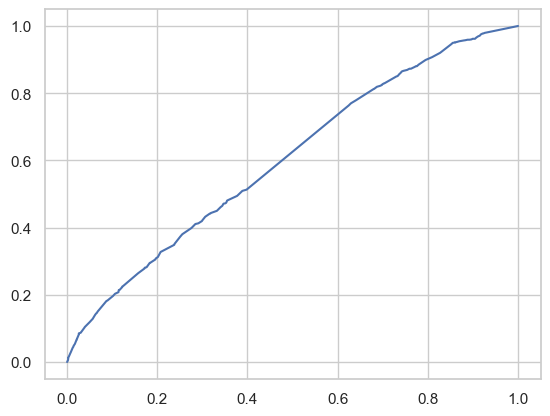

In [86]:
fpr, tpr, tresholds = roc_curve(y_test,tree_best.predict_proba(X_test_transformed_df)[:, 1])
plt.plot(fpr,tpr)

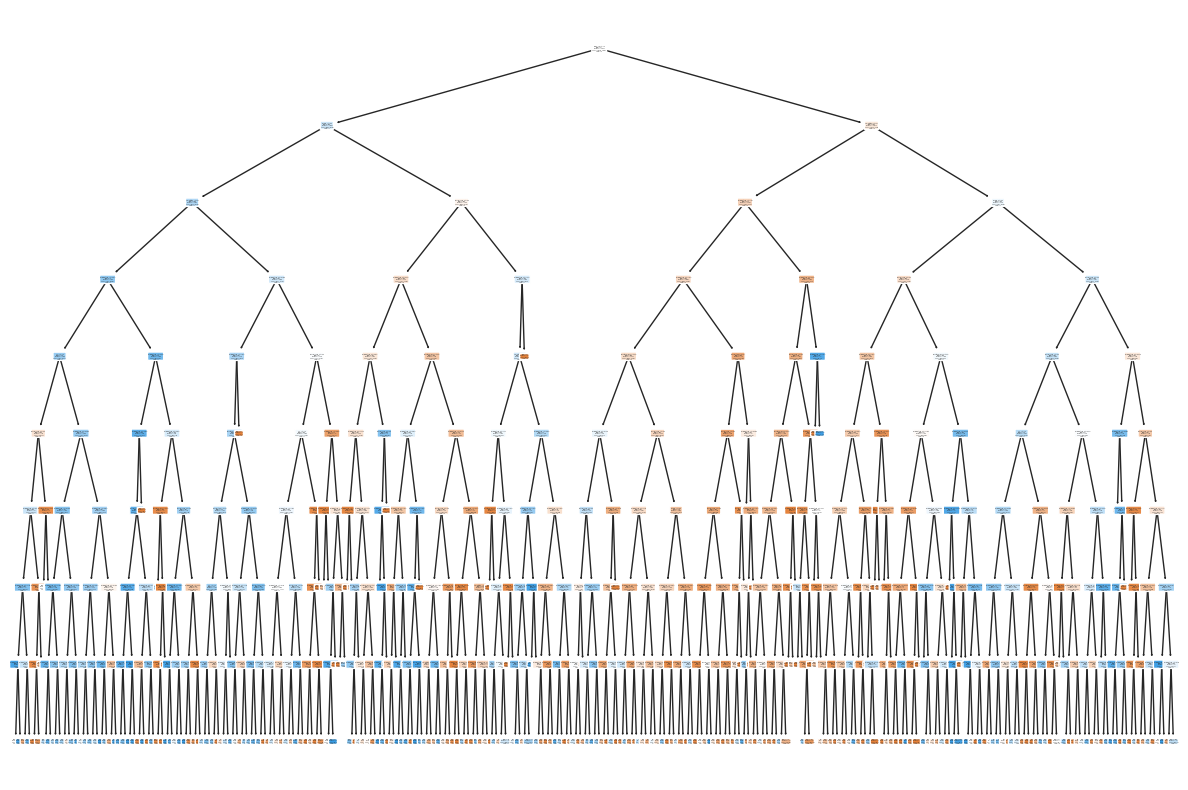

In [87]:
from sklearn.tree import plot_tree

# Get the feature names
feature_names = X_train_resampled_transformed_df.columns

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree_best, filled=True, feature_names=feature_names, class_names=['0', '1'], rounded=True)
plt.show()

2.Random Forest

In [88]:
#create model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
# Define the hyperparameters to search
params_rf = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto'],  # Number of features to consider for the best split
    'bootstrap': [True]  # Whether bootstrap samples are used when building trees
}

# Define GridSearchCV and RandomizedSearchCV
#gridsearch_rf = GridSearchCV(rf, params_rf, cv=10, scoring='recall')
randomsearch_rf = RandomizedSearchCV(rf, params_rf, cv=10, n_iter=10, scoring='recall', random_state=42)

# Fit models
#gridsearch_rf.fit(X_train_resampled_transformed_df, y_train_resampled)
randomsearch_rf.fit(X_train_resampled_transformed_df, y_train_resampled)

# Get the best parameters
#print("Best parameters for gridsearch_rf: ", gridsearch_rf.best_params_)
print("Best parameters for randomsearch_rf: ", randomsearch_rf.best_params_)

/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

Best parameters for randomsearch_rf:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [89]:
# Apply the best parameters
rf_best = RandomForestClassifier(**randomsearch_rf.best_params_)

# Perform cross-validation
cv_scores_knn = cross_val_score(rf_best, X_train_resampled_transformed_df, y_train_resampled, cv=10, scoring='recall')
print("Cross-validation scores for RandomForest: ", cv_scores_knn)

# Fit the models with the best parameters
rf_best.fit(X_train_resampled_transformed_df, y_train_resampled)

# Evaluate on the test set
y_pred_rf = rf_best.predict(X_test_transformed_df)

#seems consistent with cross_validation, no overfitting

/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

Cross-validation scores for RandomForest:  [0.73054214 0.84004294 0.9194847  0.9382716  0.93344069 0.93186695
 0.92811159 0.92328326 0.92757511 0.92274678]


/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [90]:
print("RandomForestClassifier Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_rf))
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1_score: ", f1_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))

RandomForestClassifier Metrics: 
Confusion Matrix:  [[6730 1282]
 [ 514  564]]
Accuracy:  0.8024202420242024
F1_score:  0.3857729138166895
Precision:  0.3055254604550379
Recall:  0.5231910946196661


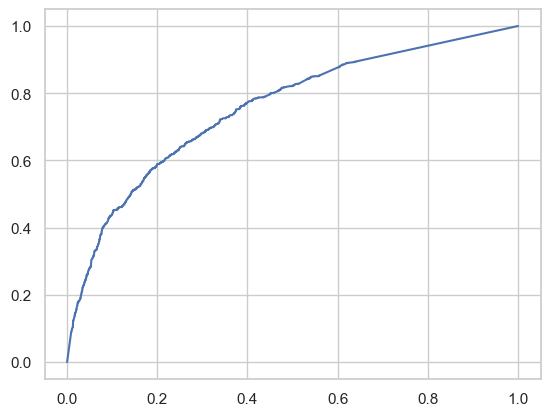

In [91]:
fpr, tpr, tresholds = roc_curve(y_test,rf_best.predict_proba(X_test_transformed_df)[:, 1])
plt.plot(fpr,tpr)

Random Forest is better but still performed not well enough in F1 score and recall,
So continue to try Ensemble methods

# Ensembel Method 1: Voting Classifier
- Create an ensemble of multiple classifiers: Random Forest, Decision Tree, KNN (3 better models through baseline) 
- adding more diverse models: SVC, Gradient Boosting
- Combine their predictions by majority voting (for classification). This can help improve overall performance.

In [92]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define the classifiers: choose 3 better models through baseline 
rf = RandomForestClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
svc = SVC(probability=True, random_state=42)  # Note: Setting probability=True for VotingClassifier
gbc = GradientBoostingClassifier(random_state=42)

#hyperparameter
param_dist_rf = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto'],  # Number of features to consider for the best split
    'bootstrap': [True]  # Whether bootstrap samples are used when building trees
}

param_dist_dt = {
    'max_depth': [3, 6, 9],            # Depth of the decision tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]      # Minimum number of samples required to be at a leaf node
}

param_dist_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean','manhattan','minkowski','chebyshev']
}

param_dist_svc = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
}

param_dist_gbc = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],         # Maximum depth of individual trees
}

# Randomized Search for each classifier
random_search_rf = RandomizedSearchCV(rf, param_dist_rf, cv=5, n_jobs=-1, n_iter=10, random_state=42, scoring='recall')
random_search_dt = RandomizedSearchCV(dt, param_dist_dt, cv=5, n_jobs=-1, n_iter=10, random_state=42, scoring='recall')
random_search_knn = RandomizedSearchCV(knn, param_dist_knn, cv=5, n_jobs=-1, random_state=42, scoring='recall')
random_search_svc = RandomizedSearchCV(svc, param_dist_svc, cv=5, n_jobs=-1, n_iter=10, random_state=42, scoring='recall')
random_search_gbc = RandomizedSearchCV(gbc, param_dist_gbc, cv=5, n_jobs=-1, n_iter=10, random_state=42, scoring='recall')

In [93]:
# Fit the RandomizedSearchCV objects to find the best hyperparameters
random_search_rf.fit(X_train_resampled_transformed_df, y_train_resampled)
random_search_dt.fit(X_train_resampled_transformed_df, y_train_resampled)
random_search_knn.fit(X_train_resampled_transformed_df, y_train_resampled)
random_search_svc.fit(X_train_resampled_transformed_df, y_train_resampled)
random_search_gbc.fit(X_train_resampled_transformed_df, y_train_resampled)

#Create the VotingClassifier with the best-tuned models from each random search
voting_classifier = VotingClassifier(
    estimators=[
        ('Random Forest', random_search_rf.best_estimator_),
        ('Decision Tree', random_search_dt.best_estimator_),
        ('KNeighbors', random_search_knn.best_estimator_),
        ('SVC', random_search_svc.best_estimator_),
        ('Gradient Boosting', random_search_gbc.best_estimator_)
    ],
    voting='soft'
)

/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

In [94]:
# fit this extended pipeline
voting_classifier.fit(X_train_resampled_transformed_df, y_train_resampled)


/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(max_features='auto',
                                                     random_state=42)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('KNeighbors',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=7,
                                                   weights='distance')),
                             ('SVC',
                              SVC(C=10, probability=True, random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         n_estimators=200,
                                                         random_state=42))],
                 voting='soft')

In [95]:
# Evaluate on the test set
y_pred_vt = voting_classifier.predict(X_test_transformed_df)

In [96]:
#evaluation
print("Votinng Classifier Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_vt))
print("Accuracy: ", accuracy_score(y_test, y_pred_vt))
print("F1_score: ", f1_score(y_test, y_pred_vt))
print("Precision: ", precision_score(y_test, y_pred_vt))
print("Recall: ", recall_score(y_test, y_pred_vt))

Votinng Classifier Metrics: 
Confusion Matrix:  [[6947 1065]
 [ 561  517]]
Accuracy:  0.8211221122112211
F1_score:  0.38872180451127814
Precision:  0.3268015170670038
Recall:  0.47959183673469385


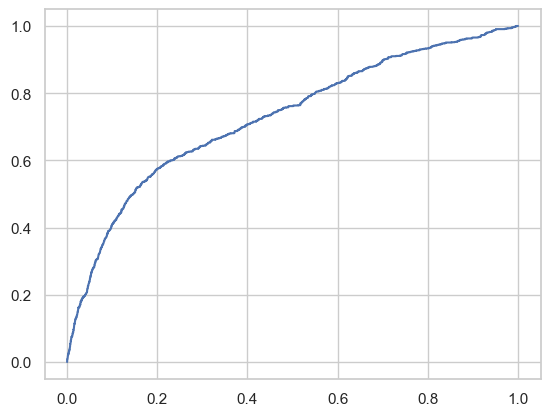

In [97]:
fpr, tpr, tresholds = roc_curve(y_test,voting_classifier.predict_proba(X_test_transformed_df)[:, 1])
plt.plot(fpr,tpr)

# Ensemble Method 2: Stacking

In [98]:
from sklearn.ensemble import StackingClassifier

# Define the base models with their best-tuned hyperparameters
base_models = [
    ('Random Forest', random_search_rf.best_estimator_),
    ('Decision Tree', random_search_dt.best_estimator_),
    ('KNeighbors', random_search_knn.best_estimator_),
    ('SVC', random_search_svc.best_estimator_),
    ('Gradient Boosting', random_search_gbc.best_estimator_)
]

# Define the meta-learner (second-level model)
meta_learner = LogisticRegression()


# Create the StackingClassifier with three levels
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5  # Cross-validation folds for training the meta-learner
)

# Fit the stacking classifier to training data
stacking_classifier.fit(X_train_resampled_transformed_df, y_train_resampled)

# Make predictions using the stacking classifier
stacking_predictions = stacking_classifier.predict(X_test_transformed_df)

/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

In [99]:
#evaluation
print("Stacking Classifier Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, stacking_predictions))
print("Accuracy: ", accuracy_score(y_test, stacking_predictions))
print("F1_score: ", f1_score(y_test, stacking_predictions))
print("Precision: ", precision_score(y_test, stacking_predictions))
print("Recall: ", recall_score(y_test, stacking_predictions))

Stacking Classifier Metrics: 
Confusion Matrix:  [[6851 1161]
 [ 526  552]]
Accuracy:  0.8144114411441145
F1_score:  0.395557147975636
Precision:  0.3222416812609457
Recall:  0.5120593692022264


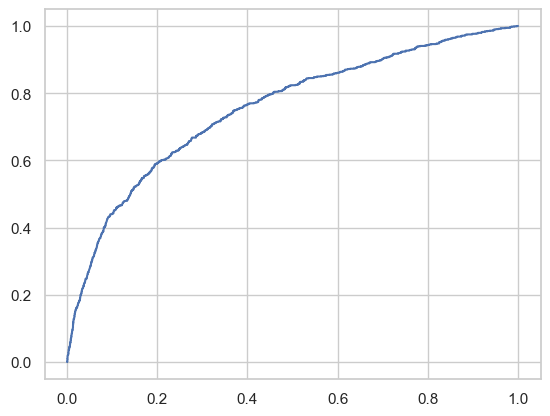

In [100]:
fpr, tpr, tresholds = roc_curve(y_test,stacking_classifier.predict_proba(X_test_transformed_df)[:, 1])
plt.plot(fpr,tpr)